In [1]:
import json
import nltk
import re
import itertools
from time import sleep
import sys
import numpy
import scipy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
with open("proj1_data.json") as fp:
    data = json.load(fp)

In [84]:
totalComment = str()
for d in data[:10000]: 
    totalComment = totalComment + ' ' + d['text']
countNaive = Counter([s.lower() for s in totalComment.split()])
totalCount = []
for key, value in countNaive.most_common(160): 
    totalCount.append(key)

In [85]:
print(totalCount)

['the', 'i', 'a', 'to', 'and', 'of', 'you', 'that', 'in', 'it', 'was', 'is', 'my', 'for', 'have', 'but', 'this', 'with', 'on', 'not', 'be', 'just', 'or', 'if', 'they', 'your', 'so', 'like', 'are', 'at', 'me', 'as', 'he', "it's", 'she', "i'm", 'about', 'when', 'we', 'all', 'because', 'from', 'her', 'out', 'would', 'get', "don't", 'had', 'what', 'one', 'up', 'people', 'can', 'an', 'do', '[deleted]', 'some', 'how', 'any', 'really', 'his', 'then', 'think', 'no', 'more', 'there', 'their', 'who', 'were', 'will', 'it.', 'them', 'by', 'has', 'only', 'time', 'go', 'know', 'even', 'got', 'been', 'good', 'new', 'after', "you're", 'never', 'please', 'make', 'than', 'am', 'still', "that's", 'him', 'did', 'being', 'into', 'much', "didn't", 'other', 'something', 'going', 'could', 'post', 'first', 'way', 'where', 'also', 'want', 'over', '-', 'most', "can't", 'say', 'see', 'pretty', 'why', 'season', 'back', "i've", 'very', 'always', 'made', 'love', 'our', 'questions', 'now', 'every', 'which', 'before',

In [77]:
# word count, no removal of punctuations
# @Param: singleText: text to process, numberOfFeatures: 0, 60, 160?
# @Return: vector of count (x in description)
def wordCountNaive(singleText, numberOfFeatures, dataConstrained): 
    totalComment = str()
    for d in dataConstrained: 
        totalComment = totalComment + d['text']
    countNaive = Counter([s.lower() for s in totalComment.split()])
    totalCount = []
    for key, value in countNaive.most_common(160): 
        totalCount.append(key)
    countNaive = Counter([s.lower() for s in singleText.split()])
    i = 0
    returnVector = []
    for word in totalCount: 
        returnVector.append(float(countNaive[word]))
    return returnVector


# word count, remove punc and stopwords to imporve model
# @Param: singleText: text to process, numberOfFeatures: 0, 60, 160?
# @Return: vector of count (x in description)
def wordCountWithStopwords(singleText, numberOfFeatures): 
    
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(singleText)
    countDict = Counter(s.lower() for s in withoutPunc if s.lower() not in stopwords.words())
    
    i = 0
    returnVector = [0.0 for i in range(0, numberOfFeatures)]
    for key, value in countDict.most_common(numberOfFeatures): 
        if i == numberOfFeatures: 
            break
        returnVector[i] = float(value)
        i = i + 1

    return returnVector

# Test: 
# print(wordCountWithStopwords([data[8]['text']], 160))
# print(data[8]['text'])

In [3]:
# word pos count, remove punc and stopwords to imporve model
# @Param: singleText: text to process
# @Return: vector of [verbcount, nouncount, adjcount]
def wordPOSCountWithStopwords(singleText): 
    
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(singleText)
    setOfStop = set(stopwords.words())
    tagged = nltk.pos_tag([s.lower() for s in withoutPunc if s.lower() not in setOfStop])
    
    verbTotal, nounTotal, adjTotal = 0, 0, 0
    counts = Counter(tag for wordType, tag in tagged)
    totalCount = len(singleText.split())
    
    for key, value in counts.items(): 
        if 'NN' in key: 
            nounTotal = nounTotal + 1
        elif 'VB' in key: 
            verbTotal = verbTotal + 1
        elif 'JJ' in key: 
            adjTotal = adjTotal + 1
            
    if totalCount > 0: 
        return [float(verbTotal) / totalCount, float(nounTotal) / totalCount, float(adjTotal) / totalCount]
    else: 
        return [0.0, 0.0, 0.0]
# Test: 
# print(wordPOSCountWithStopwords(data[3]['text']))
# print(data[3]['text'])

In [4]:
def hasURL(text): 
    if re.match(r"(http://[^ ]+)", text) != None: 
        return 1.0
    else: 
        return 0.0

In [5]:
def pythonListTranspose(xl): 
    return list(map(list, itertools.zip_longest(*xl)))

In [78]:
# Feature Parser
# @Param: dataVector: sliced original dataset, wordCountFunction: <str> -> ndarray<float>, 
# wordPOSFunction: str -> list<float>, numberOfTextFeature: 0 to shut down Text Processing (Text Features)
# featureType: 
# @Return: tuple<ndarray, list>: xEngineered, yExtracted: rows: vector<samplePoint>, samplePoint[0->2]: basic Features, 
# samplePoint[3->162]: text, samplePoint[163->167]: extra
def parseFeatures(dataVector, wordCountFunction, numberOfTextFeatures, featureType): 
    y = []
    childrenFeature = []
    controversialityFeature = []
    isRootFeature = []
    processedTextFeature = []
    verbFeature = []
    nounFeature = []
    adjFeature = []
    urlFeature = []
    identityFeature = []
    c = 0
    lenV = len(dataVector)
    for dataPoint in dataVector: 
        
        # Basic Features
        y.append(float(dataPoint['popularity_score']))
        if 'children' in featureType: 
            childrenFeature.append(float(dataPoint['children']))
        if 'controv' in featureType: 
            controversialityFeature.append(float(dataPoint['controversiality']))
        identityFeature.append(1.0)
        isRootVar = -1.0
        if 'isRoot' in featureType: 
            if dataPoint['is_root'] == True: 
                isRootVar = 1.0
                isRootFeature.append(isRootVar)
            else: 
                isRootVar = 0.0
                isRootFeature.append(isRootVar)
        
        # Text Features: 0 to shut down text feature
        if numberOfTextFeatures > 0 and 'text' in featureType: 
            processedTextFeature.append(wordCountFunction(dataPoint['text'], numberOfTextFeatures, dataVector))
        
        # Extra Features
        if 'noun' in featureType or 'verb' in featureType or 'adj' in featureType: 
            wordAnalysis = wordPOSCountWithStopwords(dataPoint['text'])
        if 'verb' in featureType: 
            verbFeature.append(wordAnalysis[0])
        if 'noun' in featureType: 
            nounFeature.append(wordAnalysis[1])
        if 'adj' in featureType: 
            adjFeature.append(wordAnalysis[2])
        if 'url' in featureType: 
            urlFeature.append(hasURL(dataPoint['text']))
        
        # Process Bar
        sys.stdout.write('\r')
        count = int((float(c) / float(lenV)) * 100)
        sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
        sleep(0.001)
        sys.stdout.flush()
        c = c + 1
    if len(processedTextFeature) > 0: 
        processedTextFeature = pythonListTranspose(processedTextFeature)
    returnTotal = [childrenFeature, controversialityFeature, isRootFeature] + processedTextFeature + [verbFeature, nounFeature, adjFeature, urlFeature, identityFeature]
    return pythonListTranspose([x for x in returnTotal if len(x) > 0]), pythonListTranspose([y])

In [7]:
def meanSquareError(valX, valY, w): 
    diffenence = numpy.power(numpy.transpose(numpy.subtract(valY, numpy.matmul(valX, w)))[0], 2)
    return numpy.divide(numpy.sum(diffenence), len(valY))

In [8]:
def closedFormLinearRegression(x, y): 
    xT = numpy.transpose(numpy.array(x))
    return numpy.matmul(numpy.matmul(scipy.linalg.inv(numpy.matmul(xT, numpy.array(x))), xT), numpy.array(y))

In [9]:
def gradientDescentLinearRegression(learnRateFunction, x, y, tol): 
    i = 1
    weight = numpy.array([[0.0] for l in range(len(x[0]))])
    weightN = numpy.array([[0.0] for l in range(len(x[0]))])
    xT = numpy.transpose(x)
    xTx = numpy.matmul(xT, x)
    xTy = numpy.matmul(xT, y)
    while True: 
        weight = weightN
        weightN = numpy.subtract(weight, 2 * learnRateFunction(i) * numpy.subtract(numpy.matmul(xTx, weight), xTy))
        i = i + 1
        if numpy.linalg.norm(numpy.subtract(weightN, weight), 2) <= tol: 
            break
    return weightN

## Experiment 1: comparison of GD and closed form

In [10]:
trainFeatures = parseFeatures(data[:10000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])
validationFeatures = parseFeatures(data[10000:11000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])
testFeatures = parseFeatures(data[11000:12000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])

[=================== ] 99%

### Closed form

In [11]:
resultClosed = closedFormLinearRegression(trainFeatures[0], trainFeatures[1])
errorClosed = meanSquareError(validationFeatures[0], validationFeatures[1], resultClosed)
errorTrained = meanSquareError(trainFeatures[0], trainFeatures[1], resultClosed)
print('result of closed form: \n', resultClosed)
print('error of closed form: \n', errorClosed)
print('error of closed form: train \n', errorTrained)

result of closed form: 
 [[ 0.37536403]
 [-1.08584747]
 [-0.22627679]
 [ 0.82092517]]
error of closed form: 
 1.0203266848431447
error of closed form: train 
 1.0846830709157251


### Gradient Descent

In [12]:
resultGradient = gradientDescentLinearRegression(lambda v: float(0.0020 / (float(v) + 7.0)), trainFeatures[0], trainFeatures[1], 0.00000005)
errorGradient = meanSquareError(validationFeatures[0], validationFeatures[1], resultGradient)
print('result of gradient descent: \n', resultGradient)
print('error of gradient descent: \n', errorGradient)

result of gradient descent: 
 [[ 0.37533109]
 [-1.07323872]
 [-0.22619048]
 [ 0.8207526 ]]
error of gradient descent: 
 1.020380306032347


同志们 在上面的学习率上做文章 runtime或者error做个plot 变上面根本算不完 变下面会改变第二个参数的精度

## Experiment 2: Text features

In [60]:
trainFeatures60 = parseFeatures(data[:10000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'text'])
trainFeatures160 = parseFeatures(data[:10000], wordCountNaive, 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [61]:
validationFeatures60 = parseFeatures(data[10000:11000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'text'])
validationFeatures160 = parseFeatures(data[10000:11000], wordCountNaive, 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

### 60 text features

In [62]:
resultClosed = closedFormLinearRegression(trainFeatures60[0], trainFeatures60[1])
errorClosed = meanSquareError(validationFeatures60[0], validationFeatures60[1], resultClosed)
errorTrained = meanSquareError(trainFeatures60[0], trainFeatures60[1], resultClosed)
# print('result of closed form: \n', resultClosed)
print('error of closed form: \n', errorClosed)
print('error of closed trained: \n', errorTrained)

error of closed form: 
 1.0075470140208287
error of closed trained: 
 1.0542104962732821


In [63]:
resultClosed160 = closedFormLinearRegression(trainFeatures160[0], trainFeatures160[1])
errorClosed160 = meanSquareError(validationFeatures160[0], validationFeatures160[1], resultClosed160)
errorTrained160 = meanSquareError(trainFeatures160[0], trainFeatures160[1], resultClosed160)
# print('result of closed form: \n', resultClosed160)
print('error of closed form: \n', errorClosed160)
print('error of closed trained: \n', errorTrained160)
len(trainFeatures160[1])

error of closed form: 
 1.0075470140208287
error of closed trained: 
 1.0542104962732821


10000

In [38]:
trainFeatures160 = parseFeatures(data[:10000], wordCountNaive, 130, ['children', 'controv', 'isRoot', 'text'])
validFeatures160 = parseFeatures(data[10000:11000], wordCountNaive, 130, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [39]:
resultClosed160 = closedFormLinearRegression(trainFeatures160[0], trainFeatures160[1])
errorClosed160 = meanSquareError(validFeatures160[0], validFeatures160[1], resultClosed160)
errorTrained160 = meanSquareError(trainFeatures160[0], trainFeatures160[1], resultClosed160)

In [40]:
print('error of closed form: \n', errorClosed160)
print('error of closed trained: \n', errorTrained160)

error of closed form: 
 258439.5164966733
error of closed trained: 
 172387.86569401412


In [64]:
import pandas as pd
import statsmodels.api as sm

In [65]:
df = pd.DataFrame(data[:10000])

In [66]:
df[['is_root']] = df[['is_root']].astype(int)

In [67]:
y = df['popularity_score']
X = df[['children', 'controversiality', 'is_root']]
X = sm.add_constant(X)
analysis = sm.OLS(y, X).fit()
analysis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       popularity_score   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     863.7
Date:                Sun, 20 Jan 2019   Prob (F-statistic):               0.00
Time:                        17:35:56   Log-Likelihood:                -14596.
No. Observations:               10000   AIC:                         2.920e+04
Df Residuals:                    9996   BIC:                         2.923e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8209      0.014     57.728      0.000       0.793       0.849
children             0.3754      0.008     48.224      0.000       0.360       0.391
controversiality    -1.0858      0.097    -11.198      0.000      -1.276      -0.896
is_root             -0.2263      0.021    -10.702      0.000      -0.268      -0.185
==============================================================================
Omnibus:                     2159.929   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23032.908
Skew:                           0.729   Prob(JB):                         0.00
Kurtosis:                      10.291   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
def parseMyFeatures(dataVector, wordCountFunction, numberOfTextFeatures, featureType): 
    y = []
    childrenFeature = []
    controversialityFeature = []
    isRootFeature = []
    rootChildren = []
    processedTextFeature = []
    identityFeature = []
    c = 0
    lenV = len(dataVector)
    for dataPoint in dataVector: 
        
        # Basic Features
        y.append(float(dataPoint['popularity_score']))
        childrenVar = 0
        if 'children' in featureType: 
            childrenVar = numpy.log(dataPoint['children']) if dataPoint['children'] != 0 else numpy.log(0.5)
            childrenFeature.append(childrenVar)
        if 'controv' in featureType: 
            controversialityFeature.append(float(dataPoint['controversiality']))
        identityFeature.append(1.0)
        isRootVar = -1.0
        if 'isRoot' in featureType: 
            if dataPoint['is_root'] == True: 
                isRootVar = 1.0
                isRootFeature.append(isRootVar)
            else: 
                isRootVar = 0.0
                isRootFeature.append(isRootVar)
                
        # Text Features: 0 to shut down text feature
        if numberOfTextFeatures > 0 and 'text' in featureType: 
            processedTextFeature.append(wordCountFunction(dataPoint['text'], numberOfTextFeatures))
        
        # Extra Features
        if 'rc' in featureType: 
            rootChildren.append(float(dataPoint['controversiality']) * childrenVar)
        
        # Process Bar
        sys.stdout.write('\r')
        count = int((float(c) / float(lenV)) * 100)
        sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
        sleep(0.001)
        sys.stdout.flush()
        c = c + 1
    if len(processedTextFeature) > 0: 
        processedTextFeature = pythonListTranspose(processedTextFeature)
    returnTotal = [childrenFeature, controversialityFeature, isRootFeature, rootChildren] + processedTextFeature + [identityFeature]
    return pythonListTranspose([x for x in returnTotal if len(x) > 0]), pythonListTranspose([y])

In [69]:
trainFeaturesMy = parseMyFeatures(data[:10000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'rc', 'text'])
validationFeaturesMy = parseMyFeatures(data[10000:11000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'rc', 'text'])
testFeaturesMy = parseMyFeatures(data[11000:12000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'rc', 'text'])

[=================== ] 99%

In [70]:
resultClosedMy = closedFormLinearRegression(trainFeaturesMy[0], trainFeaturesMy[1])
errorClosedMy = meanSquareError(validationFeaturesMy[0], validationFeaturesMy[1], resultClosedMy)
errorTrainedMy = meanSquareError(trainFeaturesMy[0], trainFeaturesMy[1], resultClosedMy)
print('error of closed form: \n', errorClosedMy)
print('error of closed form: train \n', errorTrainedMy)

error of closed form: 
 1.020489356432128
error of closed form: train 
 1.0438776190466201


### Forward Selection

In [73]:
import pandas
allData = parseFeatures(data[:11000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'text'])
train = pandas.DataFrame(allData[0])

[=================== ] 99%

In [74]:
allData[1][:5]

[[1.254698160267241],
 [0.5098127108953306],
 [0.37082680372624166],
 [-0.272842545494951],
 [0.5601496777971341]]

In [75]:
fullPredictors = set([i for i in range(0, 64)])
print(fullPredictors)
levelBest = [[sys.float_info.max, set()]]
c = 0
for k in range(1, 64): 
    
    prevBest = levelBest[-1][1]
    currentPredictors = fullPredictors - prevBest
    mseVal = []
    
    for predictor in currentPredictors: 
        selected = prevBest | set([predictor])
        
        trainX = (train[list(selected)].values)[:10000]
        validX = (train[list(selected)].values)[10000:11000]
        trainY = allData[1][:10000]
        validY = allData[1][10000:11000]
        
        try: 
            resultW = closedFormLinearRegression(trainX, trainY)
        except: 
            continue
        mseVal.append([meanSquareError(validX, validY, resultW), selected])
    
    if len(mseVal) > 0: 
        levelBest.append(min(mseVal, key = lambda x: x[1]))
    
    # Process Bar
    sys.stdout.write('\r')
    count = int((float(c) / float(65)) * 100)
    sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
    sleep(0.001)
    sys.stdout.flush()
    c = c + 1

trainX = (train[list(fullPredictors)].values)[:10000]
validX = (train[list(fullPredictors)].values)[10000:11000]
trainY = allData[1][:10000]
validY = allData[1][10000:11000]
resultW = closedFormLinearRegression(trainX, trainY)
mseVal.append([selected, meanSquareError(validX, validY, resultW)])

bestOfAll = sorted(levelBest, key = lambda v: v[0])[0]

print(bestOfAll)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}
[=================== ] 95%[1.329952589487065, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62}]


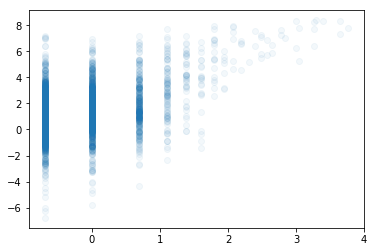

In [220]:
import matplotlib.pyplot as plt
plt.scatter(numpy.transpose(trainFeaturesMy[0])[0], numpy.transpose(trainFeaturesMy[1]), alpha = 0.05)

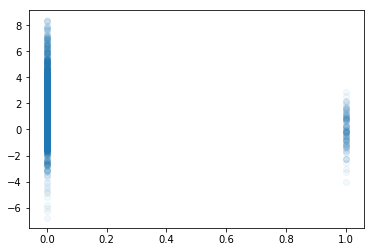

In [221]:
plt.scatter(numpy.transpose(trainFeaturesMy[0])[1], numpy.transpose(trainFeaturesMy[1]), alpha = 0.05)

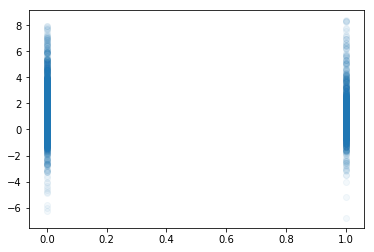

In [222]:
plt.scatter(numpy.transpose(trainFeaturesMy[0])[2], numpy.transpose(trainFeaturesMy[1]), alpha = 0.05)

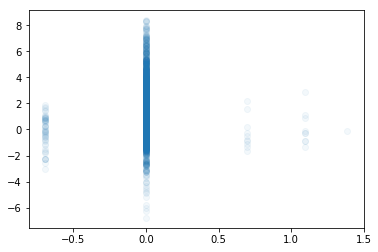

In [223]:
plt.scatter(numpy.transpose(trainFeaturesMy[0])[3], numpy.transpose(trainFeaturesMy[1]), alpha = 0.05)

/Users/yuxiangma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/yuxiangma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


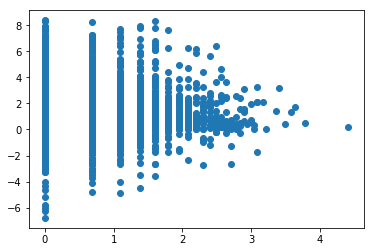

In [225]:
plt.scatter(numpy.log(numpy.transpose(trainFeaturesMy[0]))[4], numpy.transpose(trainFeaturesMy[1]))